In [1]:

import numpy as np
#import pandas as pd
import geopandas as gpd
import contextily as cx
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
from shapely.geometry import Point, LineString
from shapely.geometry import asPoint
from numpy import asarray
import syslog
import paho.mqtt.client as mqtt #import library
from queue import Queue
import sys
import time
import os
#import datetime 
import math
import json
import signal
import pdb
import signal
from pathlib import Path
from argparse import ArgumentParser
from decimal import Decimal

from django.utils.dateparse import parse_datetime
from django.contrib.gis.geos import Point, LineString
from django.conf import settings
from django.utils import timezone
from django.utils.timezone import make_aware

utm = None # will hold the computed EPSG

file_dir =os.path.dirname(sys.argv[0])

sys.path.insert(0, '.')
sys.path.insert(0, '..')

# to get django to work with JN
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


try:
    import manage # pylint: disable=unused-import
except ImportError as err:
    sys.stderr.write("Could not run script! Is manage.py not in the current"\
        "working directory, or is the environment not configured?:\n"\
        f"{err}\n")
    sys.exit(1)



from races.models import Race, Boat, RaceTick


In [2]:
def lonlat2UTM(lonlat):  # lonlat is [long, lat]
    utm = (np.floor((lonlat[0] + 180) / 6) % 60) + 1
    if(lonlat[1] > 0): 
        utm = utm + 32600
    else:
        utm = utm + 32700
    return int(utm)

def rotation(r):
    return np.asarray([np.cos(r), -np.sin(r), np.sin(r), np.cos(r)]).reshape(2, 2)



In [7]:
# try to list races
race_list = Race.objects.values('name').distinct()
print(race_list)

<QuerySet [{'name': 'Test Race'}]>


In [8]:
for e in Race.objects.filter(boats=6).values('boats','ticks'):
    print(e)

{'boats': 6, 'ticks': 1122}
{'boats': 6, 'ticks': 1123}
{'boats': 6, 'ticks': 1124}
{'boats': 6, 'ticks': 1125}
{'boats': 6, 'ticks': 1126}
{'boats': 6, 'ticks': 1127}
{'boats': 6, 'ticks': 1128}
{'boats': 6, 'ticks': 1129}
{'boats': 6, 'ticks': 1130}
{'boats': 6, 'ticks': 1131}
{'boats': 6, 'ticks': 1132}
{'boats': 6, 'ticks': 1133}
{'boats': 6, 'ticks': 1134}
{'boats': 6, 'ticks': 1135}
{'boats': 6, 'ticks': 1136}
{'boats': 6, 'ticks': 1137}
{'boats': 6, 'ticks': 1138}
{'boats': 6, 'ticks': 1139}
{'boats': 6, 'ticks': 1140}
{'boats': 6, 'ticks': 1141}
{'boats': 6, 'ticks': 1142}
{'boats': 6, 'ticks': 1143}
{'boats': 6, 'ticks': 1144}
{'boats': 6, 'ticks': 1145}
{'boats': 6, 'ticks': 1146}
{'boats': 6, 'ticks': 1147}
{'boats': 6, 'ticks': 1148}
{'boats': 6, 'ticks': 1149}
{'boats': 6, 'ticks': 1150}
{'boats': 6, 'ticks': 1151}
{'boats': 6, 'ticks': 1152}
{'boats': 6, 'ticks': 1153}
{'boats': 6, 'ticks': 1154}
{'boats': 6, 'ticks': 1155}
{'boats': 6, 'ticks': 1156}
{'boats': 6, 'ticks'

In [9]:
for f in RaceTick.objects.values('boat', 'ctime').filter( id=1780):
    print(str(f['boat']) + ", " + str(f['ctime']))
    

5, 2022-09-14 19:07:59.400000+00:00


In [10]:
t = RaceTick.objects.values('ctime', 'boat', 'course_t').order_by('ctime')
for tmp in t: 
    print(tmp['ctime'], tmp['boat'], tmp['course_t'])

2022-09-14 15:40:50+00:00 1 -177.1875
2022-09-14 15:40:50.400000+00:00 1 -177.1875
2022-09-14 15:40:51+00:00 1 -177.1875
2022-09-14 15:40:51.400000+00:00 1 -177.1875
2022-09-14 15:40:52+00:00 1 -177.1875
2022-09-14 15:40:52.400000+00:00 1 -177.1875
2022-09-14 15:40:53+00:00 1 -177.1875
2022-09-14 15:40:53.400000+00:00 1 -177.1875
2022-09-14 15:40:54+00:00 1 -177.1875
2022-09-14 15:40:54.400000+00:00 1 -177.1875
2022-09-14 15:40:55+00:00 1 -177.1875
2022-09-14 15:40:55.400000+00:00 1 -177.1875
2022-09-14 15:40:56+00:00 1 -177.1875
2022-09-14 15:40:56.400000+00:00 1 -177.1875
2022-09-14 15:40:57+00:00 1 -177.1875
2022-09-14 15:40:57.400000+00:00 1 -177.1875
2022-09-14 15:40:58+00:00 1 -177.1875
2022-09-14 15:40:58.400000+00:00 1 -177.1875
2022-09-14 15:40:59+00:00 1 -177.1875
2022-09-14 15:40:59.400000+00:00 1 -177.1875
2022-09-14 15:41:00+00:00 1 -177.1875
2022-09-14 15:41:00.400000+00:00 1 -177.1875
2022-09-14 15:41:01+00:00 1 -177.1875
2022-09-14 15:41:01.400000+00:00 1 -177.1875
2022

In [11]:
RaceTick.objects.values_list('boat', flat=True).distinct()

<QuerySet [7, 1, 5, 4, 2, 6, 3]>

In [93]:
start_t = datetime(2022,9,14, 19,4,50,0, tzinfo=timezone.utc)
end_t = datetime(2022,9,14, 19,25,50,0, tzinfo=timezone.utc)
tmp_data = RaceTick.objects.filter(ctime__gte=start_t, ctime__lte=end_t, boat=7)\
.values('ctime', 'boat', 'course_t', 'error_2d').order_by('ctime')
for tmp in tmp_data:
    print(tmp['ctime'], tmp['boat'], tmp['course_t'], tmp['error_2d'])

2022-09-14 19:04:50.200000+00:00 7 -1.4063 0.0
2022-09-14 19:04:51.800000+00:00 7 -1.4063 0.0
2022-09-14 19:04:52.200000+00:00 7 -1.4063 0.0
2022-09-14 19:04:53.800000+00:00 7 -1.4063 0.0
2022-09-14 19:04:54.200000+00:00 7 -1.4063 0.0
2022-09-14 19:04:55.800000+00:00 7 -1.4063 0.0
2022-09-14 19:04:56.200000+00:00 7 -1.4063 0.0
2022-09-14 19:04:57.800000+00:00 7 -1.4063 0.0
2022-09-14 19:04:58.200000+00:00 7 -1.4063 0.0
2022-09-14 19:04:59.800000+00:00 7 -98.4375 0.0
2022-09-14 19:05:00.200000+00:00 7 -84.3750 0.0
2022-09-14 19:05:01.800000+00:00 7 -111.0938 0.0
2022-09-14 19:05:02.200000+00:00 7 -111.0938 0.0
2022-09-14 19:05:03.800000+00:00 7 -105.4688 0.0
2022-09-14 19:05:04.200000+00:00 7 -98.4375 0.0
2022-09-14 19:05:05.800000+00:00 7 -101.2500 0.0
2022-09-14 19:05:06.200000+00:00 7 -94.2188 0.0
2022-09-14 19:05:07.800000+00:00 7 -91.4063 0.0
2022-09-14 19:05:08.200000+00:00 7 -97.0313 0.0
2022-09-14 19:05:09.800000+00:00 7 -104.0625 0.3
2022-09-14 19:05:10.200000+00:00 7 -92.8125 

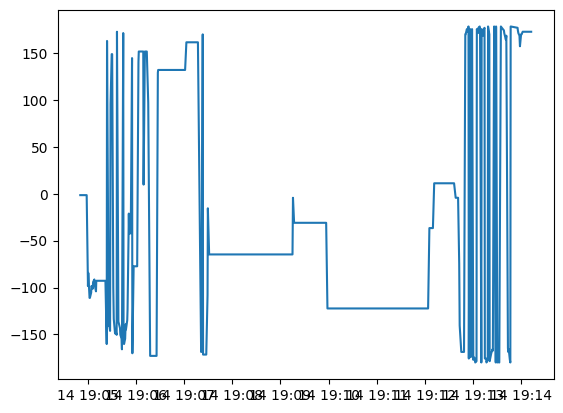

In [13]:
x = tmp_data.values_list('ctime', flat=True)
y = tmp_data.values_list('course_t', flat=True)
plt.plot(x,y)

In [109]:
start_t = datetime(2022,9,14, 18,30,50,0, tzinfo=timezone.utc)
end_t = datetime(2022,9,14, 19,55,50,0, tzinfo=timezone.utc)
tmp_data = RaceTick.objects.filter(ctime__gte=start_t, ctime__lte=end_t, boat=7)\
.values('ctime', 'coord', 'error_2d').order_by('ctime')

In [101]:
tmp_data.values('coord')[0]['coord'].coords

(-71.0876136, 42.3585347)

In [102]:
tmp_data.values('coord')

<QuerySet [{'coord': <Point object at 0x7f1905626310>}, {'coord': <Point object at 0x7f1905626910>}, {'coord': <Point object at 0x7f1905626710>}, {'coord': <Point object at 0x7f1905626410>}, {'coord': <Point object at 0x7f1905626c90>}, {'coord': <Point object at 0x7f1905626e10>}, {'coord': <Point object at 0x7f1905626f10>}, {'coord': <Point object at 0x7f190871c090>}, {'coord': <Point object at 0x7f190871c190>}, {'coord': <Point object at 0x7f190871c310>}, {'coord': <Point object at 0x7f190871c410>}, {'coord': <Point object at 0x7f190871c510>}, {'coord': <Point object at 0x7f190871c610>}, {'coord': <Point object at 0x7f190871c710>}, {'coord': <Point object at 0x7f190871c810>}, {'coord': <Point object at 0x7f190871c910>}, {'coord': <Point object at 0x7f190871ca10>}, {'coord': <Point object at 0x7f190871c290>}, {'coord': <Point object at 0x7f190871cb90>}, {'coord': <Point object at 0x7f190871cc90>}, '...(remaining elements truncated)...']>

In [103]:
# get the long, lat of a point and calculate the new srid using the function defined at the top
new_srid = lonlat2UTM(tmp_data.values('coord')[0]['coord'])
print(new_srid)

32619


In [104]:
len(tmp_data)

528

In [110]:
# create an array to hold the data to plot
# time, easting, northing, error_2d
plot_array = np.full([len(tmp_data), 4], None)

# transform the values in tmp_data
for i, tmp_a in enumerate(tmp_data.values('coord','error_2d')):
    #print(type(tmp_a['coord']))
    tmp_coord = tmp_a['coord'].transform(new_srid, clone=True)
    plot_array[i,1] = tmp_coord[0]
    plot_array[i,2] = tmp_coord[1]
    plot_array[i,3] = tmp_a['error_2d']


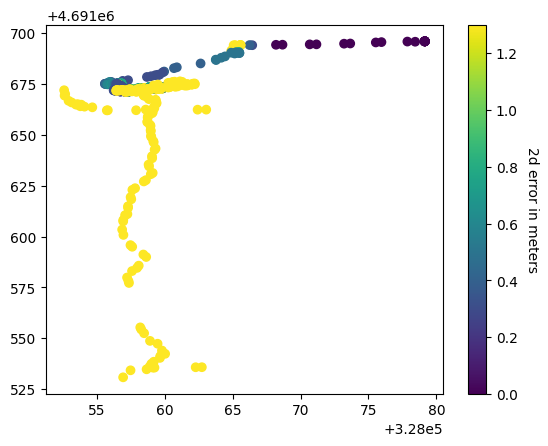

In [135]:
fig, ax = plt.subplots(1)
pc=ax.scatter(plot_array[:,1], plot_array[:,2], c=plot_array[:,3], cmap='viridis', label='error')
cbar = fig.colorbar(pc)
cbar.set_label('2d error in meters', rotation=270, labelpad=15)
#plt.gca().set_aspect('equal', adjustable='box')


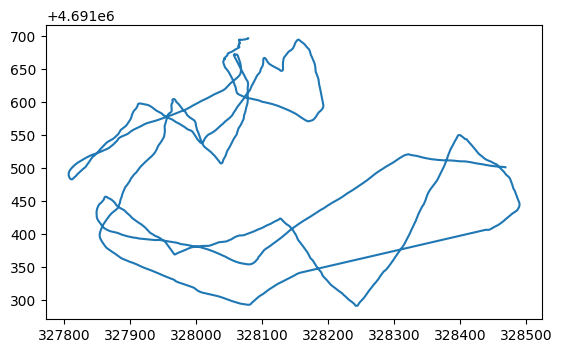

In [139]:
start_t = datetime(2022,9,14, 17,30,50,0, tzinfo=timezone.utc)
end_t = datetime(2022,9,14, 21,55,50,0, tzinfo=timezone.utc)
tmp_data = RaceTick.objects.filter(ctime__gte=start_t, ctime__lte=end_t, boat=5)\
.values('ctime', 'coord').order_by('ctime')
# create an array to hold the data to plot
# time, easting, northing
plot_array = np.full([len(tmp_data), 3], None)

# transform the values in tmp_data
for i, tmp_a in enumerate(tmp_data.values('coord')):
    #print(type(tmp_a['coord']))
    tmp_coord = tmp_a['coord'].transform(new_srid, clone=True)
    plot_array[i,1] = tmp_coord[0]
    plot_array[i,2] = tmp_coord[1]
    #plot_array[i,1] = tmp_coord

plt.plot(plot_array[:,1], plot_array[:,2])
plt.gca().set_aspect('equal', adjustable='box')

32619


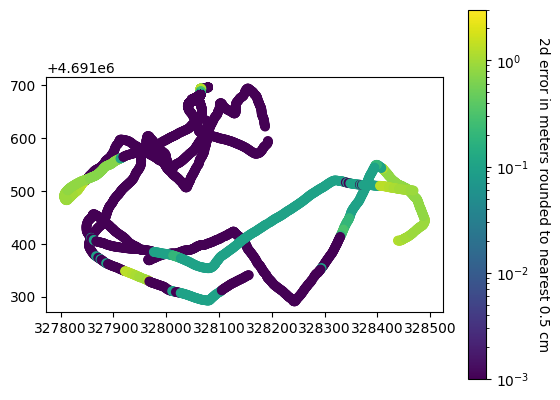

In [8]:
# get the long, lat of a point and calculate the new srid using the function defined at the top
new_srid = lonlat2UTM(tmp_data.values('coord')[0]['coord'])
print(new_srid)

start_t = datetime(2022,9,14, 17,30,50,0, tzinfo=timezone.utc)
end_t = datetime(2022,9,14, 21,55,50,0, tzinfo=timezone.utc)
tmp_data = RaceTick.objects.filter(ctime__gte=start_t, ctime__lte=end_t, boat=5)\
.values('ctime', 'coord', 'error_2d').order_by('ctime')
# create an array to hold the data to plot
# time, easting, northing
plot_array = np.full([len(tmp_data), 4], None)

# transform the values in tmp_data
for i, tmp_a in enumerate(tmp_data.values('coord', 'error_2d')):
    #print(tmp_a)
    tmp_coord = tmp_a['coord'].transform(new_srid, clone=True)
    plot_array[i,1] = tmp_coord[0]
    plot_array[i,2] = tmp_coord[1]
    plot_array[i,3] = tmp_a['error_2d'] + Decimal(0.001)

fig, ax = plt.subplots(1)
pc=ax.scatter(plot_array[:,1], plot_array[:,2], c=plot_array[:,3], cmap='viridis', 
              norm=mpl.colors.LogNorm(vmin=0.001, vmax=3.),label='error')
cbar = fig.colorbar(pc)
cbar.set_label('2d error in meters rounded to nearest 0.5 cm', rotation=270, labelpad=15)
# plt.gca().set_aspect('equal', adjustable='box')

plt.gca().set_aspect('equal', adjustable='box')

In [177]:
print(type(tmp_a['error_2d']))

<class 'decimal.Decimal'>


In [57]:
print(myPoint3857[1])

4435426.171561749
